<a href="https://colab.research.google.com/github/hanjaehee77/wogml/blob/main/CW_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [4]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [1]:
from urllib.request import urlretrieve
import json

imagenet_json, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [5]:
print(imagenet_labels[18])

magpie


In [6]:
imsize = 299

preprocess = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor(),
])

In [7]:
import matplotlib.pyplot as plt
import PIL

In [8]:
def image_loader(path):
    image = PIL.Image.open(path)
    image = preprocess(image).unsqueeze(0)
    return image.to(device, torch.float)

In [11]:
url = "https://previews.123rf.com/images/evdoha/evdoha1209/evdoha120903876/15427542-%EB%91%90%EB%A0%A4%EC%9B%8C-%EC%96%BC%EB%A3%A9-%EA%B3%A0%EC%96%91%EC%9D%B4.jpg"
image_path, _ = urlretrieve(url)
image = image_loader(image_path)

In [12]:
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)

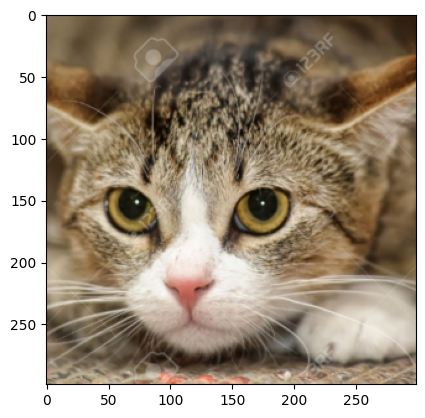

In [13]:
plt.figure()
imshow(image)

In [14]:
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))

    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [15]:
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
).to(device).eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 197MB/s] 


In [16]:
outputs = model(image)
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
print("< 가장 높은 확률을 가지는 클래스들 >")
for i in outputs[0].topk(5)[1]:
    print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 50.9151%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 21.7954%
인덱스: 282 / 클래스명: tiger cat / 확률: 19.5586%
인덱스: 287 / 클래스명: lynx, catamount / 확률: 1.1957%
인덱스: 728 / 클래스명: plastic bag / 확률: 0.1108%


In [51]:
def cw_attack(model, images, labels, targeted, c, k, iters, lr):
    images = images.to(device)
    labels = labels.to(device)

    def f(x):
        outputs = model(x)
        one_hot_labels = torch.eye(len(outputs[0])).to(device)[labels]

        i, _ = torch.max((1 - one_hot_labels) * outputs, dim=1)
        j = torch.masked_select(outputs, one_hot_labels.bool())

        if targeted:
            return torch.clamp(i - j, min=-k) # 값이 k 이하인 경우 0으로 처리
        else:
            return torch.clamp(j - i, min=-k) # 값이 k 이하인 경우 0으로 처리


    adv_image = torch.zeros_like(images).to(device)
    adv_image.requires_grad = True

    optimizer = optim.Adam([adv_image], lr=lr)

    for i in range(iters):
        box_constrained_adv_image = 1 / 2 * (nn.Tanh()(adv_image) + 1)

        loss1 = nn.MSELoss(reduction='sum')(box_constrained_adv_image, images)

        loss2 = torch.sum(c * f(box_constrained_adv_image))

        cost = loss1 + loss2

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if i % 100 == 0:
            print("Step:", i, "/ Cost:", cost.item())

    box_constrained_adv_image = 1 / 2 * (nn.Tanh()(adv_image) + 1).detach_()

    return box_constrained_adv_image


In [53]:
targeted = True
c = 100
k = 0
iters = 1000
lr = 0.01

label = [18]
label = torch.Tensor(label)
label = label.type(torch.long)


adv_image = cw_attack(model, image, label, targeted, c, k, iters, lr)

Step: 0 / Cost: 13137.728515625
Step: 100 / Cost: 6987.00341796875
Step: 200 / Cost: 3540.660400390625
Step: 300 / Cost: 1874.1512451171875
Step: 400 / Cost: 1183.6409912109375
Step: 500 / Cost: 754.69677734375
Step: 600 / Cost: 461.58123779296875
Step: 700 / Cost: 281.18121337890625
Step: 800 / Cost: 261.0735778808594
Step: 900 / Cost: 245.83670043945312


In [55]:
outputs = model(adv_image)

percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100

print("< 가장 높은 확률을 가지는 클래스들 >")
for i in outputs[0].topk(5)[1]:
    print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 40.3166%
인덱스: 17 / 클래스명: jay / 확률: 13.843%
인덱스: 84 / 클래스명: peacock / 확률: 10.9291%
인덱스: 749 / 클래스명: quill, quill pen / 확률: 3.7081%
인덱스: 19 / 클래스명: chickadee / 확률: 2.1586%


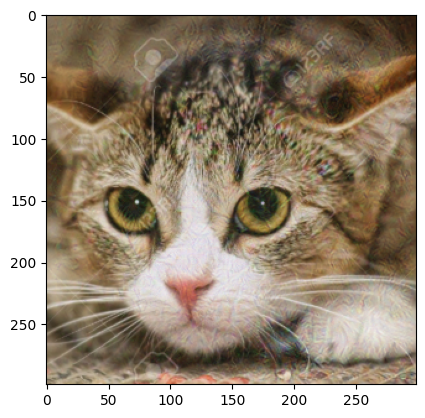

In [56]:
plt.figure()
imshow(adv_image)